## Предсказание выживших на Титанике

Гибель «Титаника» — одно из самых печально известных кораблекрушений в истории.

15 апреля 1912 года во время своего первого рейса «Титаник», считавшийся «непотопляемым», затонул после столкновения с айсбергом. К сожалению, спасательных шлюпок на всех на борту не хватило, в результате чего из 2224 пассажиров и членов экипажа погибли 1502 человека.

Хотя в выживании был некоторый элемент удачи, кажется, что у некоторых групп людей было больше шансов выжить, чем у других.

В этом задании необходимо построить прогностическую модель, отвечающую на вопрос: «У каких людей больше шансов выжить?» используя данные о пассажирах (например, имя, возраст, пол, социально-экономический класс и т. д.).

In [113]:
# импорт библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

In [114]:
# загружаем папку и файлы в ней
path = "/Users/ven89/OneDrive/Desktop/Питон соревнования/Титаник"
os.chdir(path)
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [115]:
# функция для вывода начальной информации по датафрейму
def begin(df):
    display(df.head())
    print('Общая информация')
    df.info()
    print('Описательная статистика')
    display(df.describe(include='all'))
    print('Пропущенные значения')
    print(df.isna().sum())
    print('Количество дубликатов: ', df.duplicated().sum())

In [116]:
# информация по обучающей выборке
begin(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Описательная статистика


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Пропущенные значения
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Количество дубликатов:  0


В обучающей выборке представлены 891 строк и 12 столбцов:
- PassengerId - Id пассажира;
- Survived - Выжил 0 = No, 1 = Yes;
- Pclass - Класс билета 1 = 1st, 2 = 2nd, 3 = 3rd;
- Name - имя пассажира;
- Sex - пол;
- Age - возраст;
- SibSp - количество братьев и сестер / супругов на борту Титаника;
- Parch - количество родителей/детей на борту Титаника;
- Ticket - номер билета;
- Fare - пассажирский тариф;
- Cabin - номер каюты;
- Embarked - порт погрузки.

Дублирующих значений нет. Наблюдаются пропущенные значения в столбцах возраст, номер каюты и порт погрузки.

Отметим, что присутствует возраст младше 1 года, необходимо рассмотреть подробнее


In [117]:
train_df.query('Age<1')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


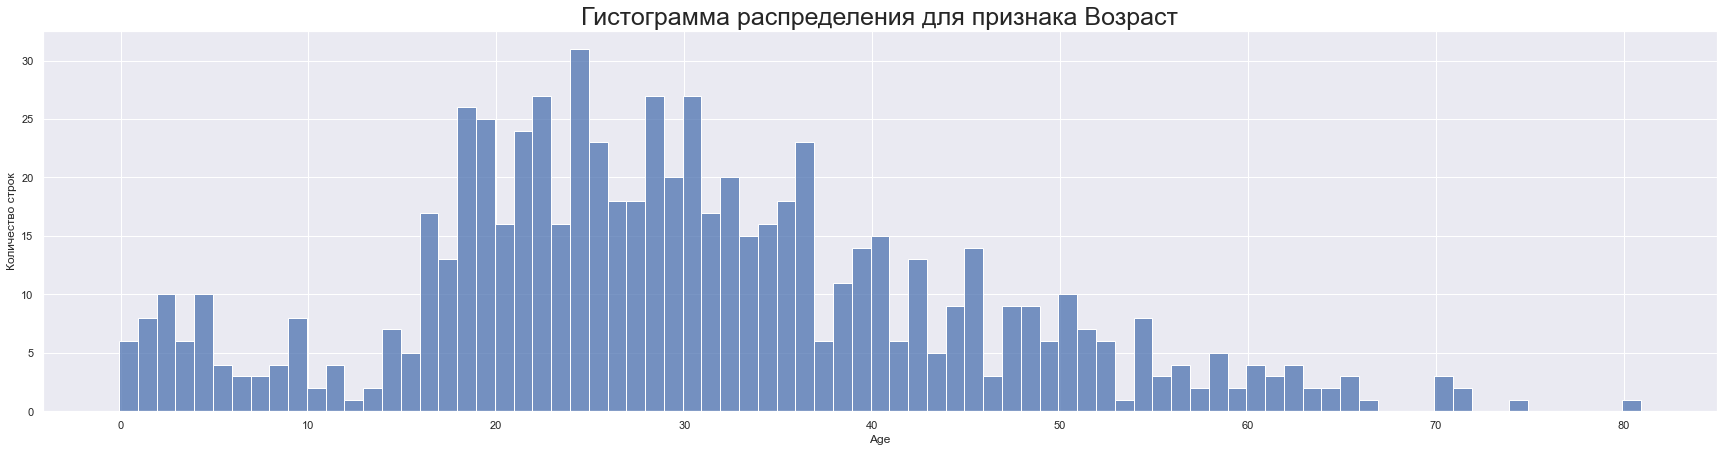

In [118]:
# построим гистаграмму распределения для признака 'Возраст'
sns.set(rc={"figure.figsize": (30, 7)})
ahs = sns.histplot(data=train_df, x='Age', discrete=True)
ahs.set_ylabel('Количество строк')
ahs.set_title('Гистограмма распределения для признака Возраст', fontsize=25);

Отметим, что присутствуют выбросы после 70 лет. Расссмотрим подробнее

In [119]:
train_df.query('Age>70')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S


In [120]:
# рассмотрим уникальные значения Порт погрузки
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [121]:
train_df.query('Pclass==3')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [122]:
# информация по тестовой выборке
begin(test_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
Описательная статистика


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


Пропущенные значения
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
Количество дубликатов:  0


In [123]:
# проверка отсутствующих столбцов в тестовой выборке
set(train_df)-set(test_df)

{'Survived'}

В тестовой выборке всего 418 значений. Присутствуют все столбцы кроме нашего таргета. Также отсутсвуют значения в столбцах Возраст, Номер билета и пассажирский тариф.

In [124]:
# посмотрим корреляцию между признаками
train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


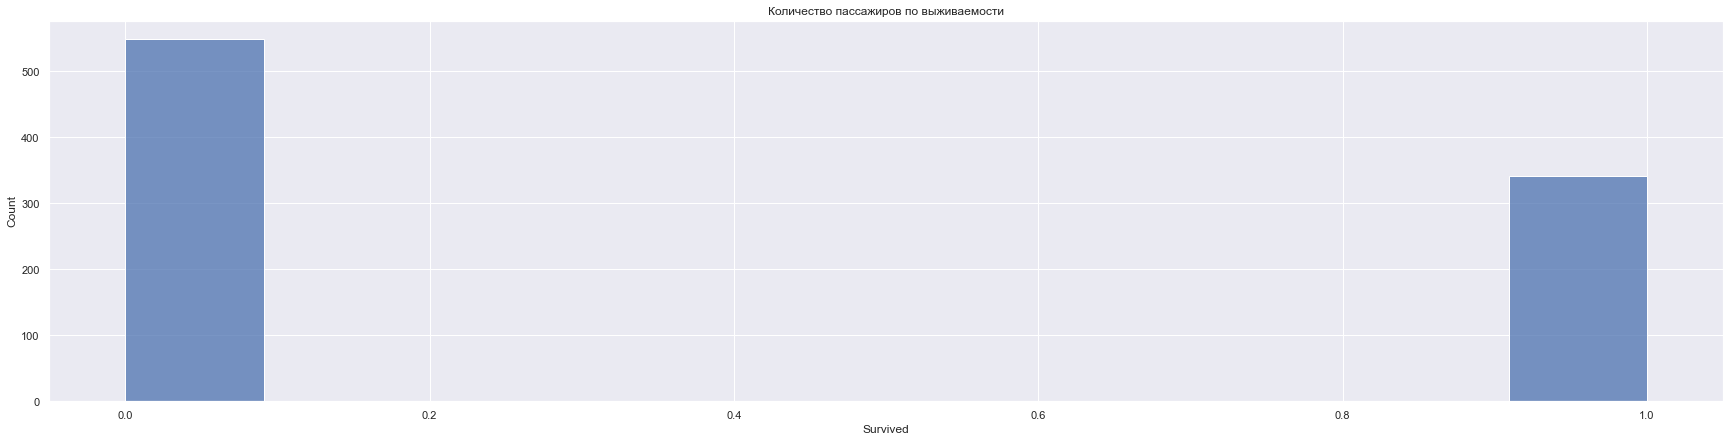

In [125]:
# посмотрим какое распределение пассажиров
plt.title("Количество пассажиров по выживаемости" )
sns.histplot(train_df['Survived']);

В обучающем датафрейме умерших пассажиров больше чем выживших почти в 2 раза. Наблюдается дисбаланс классов.

In [126]:
surv_df = train_df.groupby(['Survived', 'Sex', 'Pclass', ]).agg(count_survived=("Survived", 'count')).reset_index()
surv_df

,Survived,Sex,Pclass,count_survived
0,0,female,1,3
1,0,female,2,6
2,0,female,3,72
3,0,male,1,77
4,0,male,2,91
5,0,male,3,300
6,1,female,1,91
7,1,female,2,70
8,1,female,3,72
9,1,male,1,45


In [127]:
nan_df = train_df[train_df['Age'].isna()]
nan_df['Pclass'].value_counts()

3    136
1     30
2     11
Name: Pclass, dtype: int64

Пропущенные значения в возрасте пассажира больше всего у пассажиров 3 класса.

In [128]:
age_df = train_df[train_df['Pclass']==3]
age_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            136
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          479
Embarked         0
dtype: int64

In [129]:
age_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


<AxesSubplot:xlabel='Survived', ylabel='Count'>

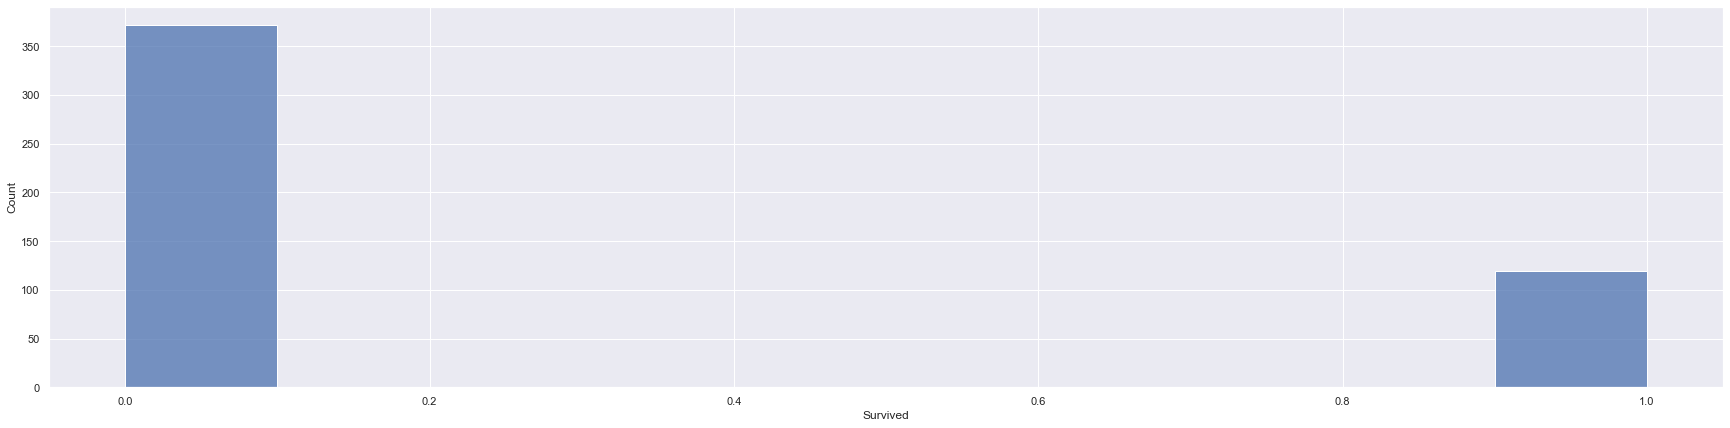

In [130]:
sns.histplot(age_df['Survived'])

In [131]:
age_df['Age'].mean()

25.14061971830986

In [132]:
age_df['Age'].median()

24.0

In [133]:
age_test_df = test_df[test_df['Pclass']==3]
age_test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             72
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          214
Embarked         0
dtype: int64

In [134]:
age_test_df['Age'].median()

24.0

In [135]:
age_test_df['Age'].mean()

24.02794520547945

Заменим медианными значениями пропущенные значения в столбце Возраст 

In [136]:
train_df['Age'] = train_df['Age'].fillna(24)
test_df['Age'] = test_df['Age'].fillna(24)

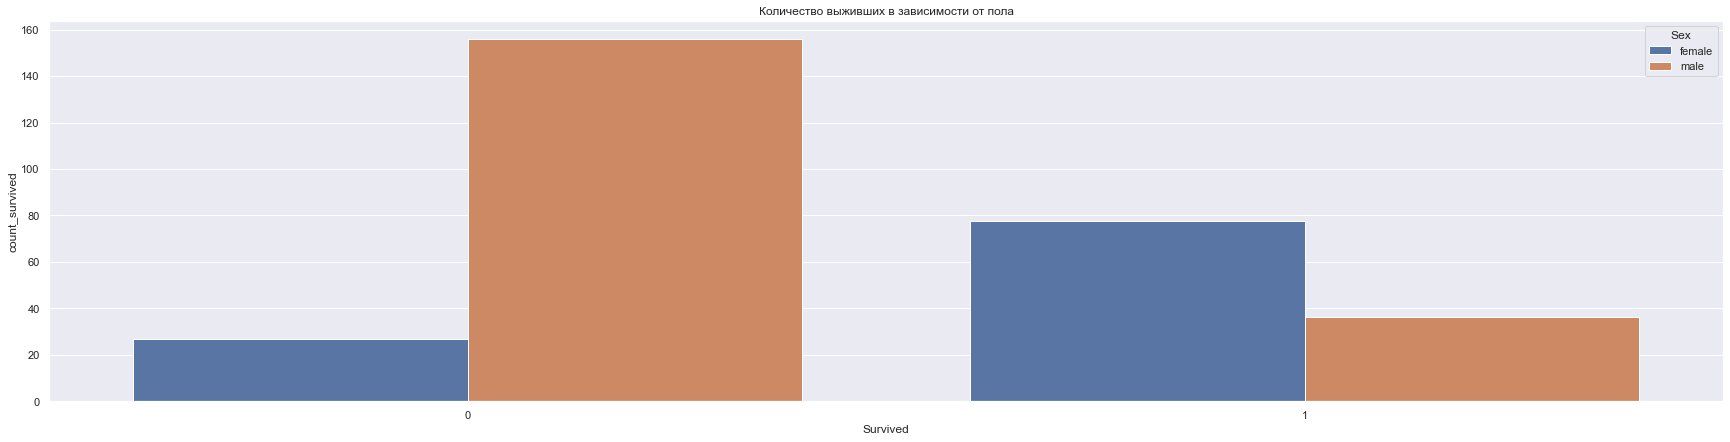

In [137]:
plt.title('Количество выживших в зависимости от пола')
sns.barplot(x="Survived",
           y="count_survived",
           hue="Sex",
           data=surv_df,
           ci=None);

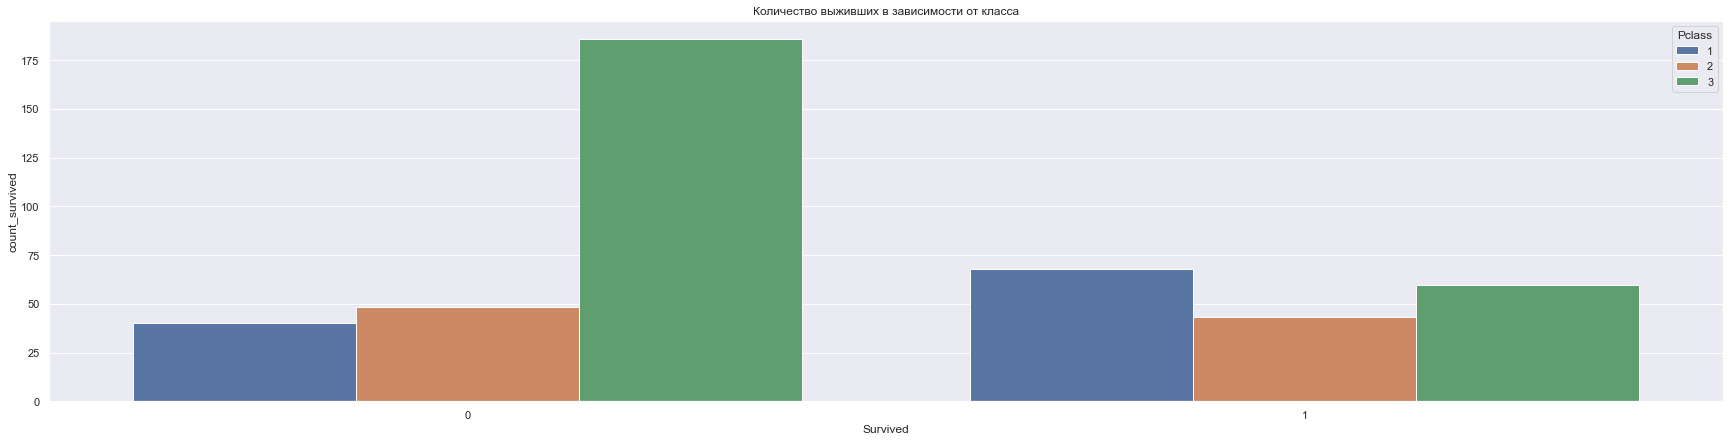

In [138]:
plt.title('Количество выживших в зависимости от класса')
sns.barplot(x="Survived",
           y="count_survived",
           hue="Pclass",
           data=surv_df,
           ci=None);

In [139]:
def get_age(age):
    if age<=10:
        return '0-10'
    elif 20>=age>10:
        return '10-20'
    elif 35>=age>20:
        return '20-35'
    elif 55>=age>35:
        return '35-55'
    elif age>55:
        return '55+'

In [140]:
train_df['age_name'] = train_df['Age'].apply(get_age)

In [141]:
age_group_df = train_df.groupby(['age_name', "Survived"]).agg(count_surv=("Survived", 'count'))
age_group_df = age_group_df.reset_index()

In [142]:
age_group_df

,age_name,Survived,count_surv
0,0-10,0,26
1,0-10,1,38
2,10-20,0,71
3,10-20,1,44
4,20-35,0,318
5,20-35,1,177
6,35-55,0,106
7,35-55,1,71
8,55+,0,28
9,55+,1,12


<AxesSubplot:xlabel='Survived', ylabel='count_surv'>

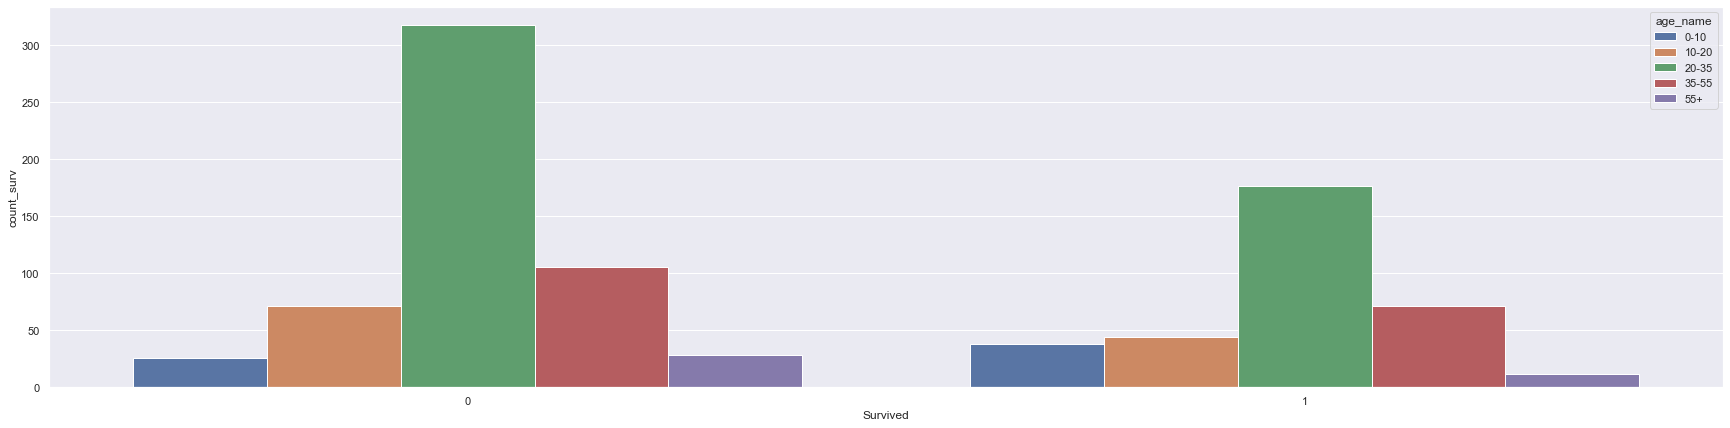

In [143]:
sns.barplot(x=age_group_df["Survived"],
           y=age_group_df["count_surv"],
           hue=age_group_df["age_name"],
           data=age_group_df)

Text(0, 0.5, 'Количество строк')

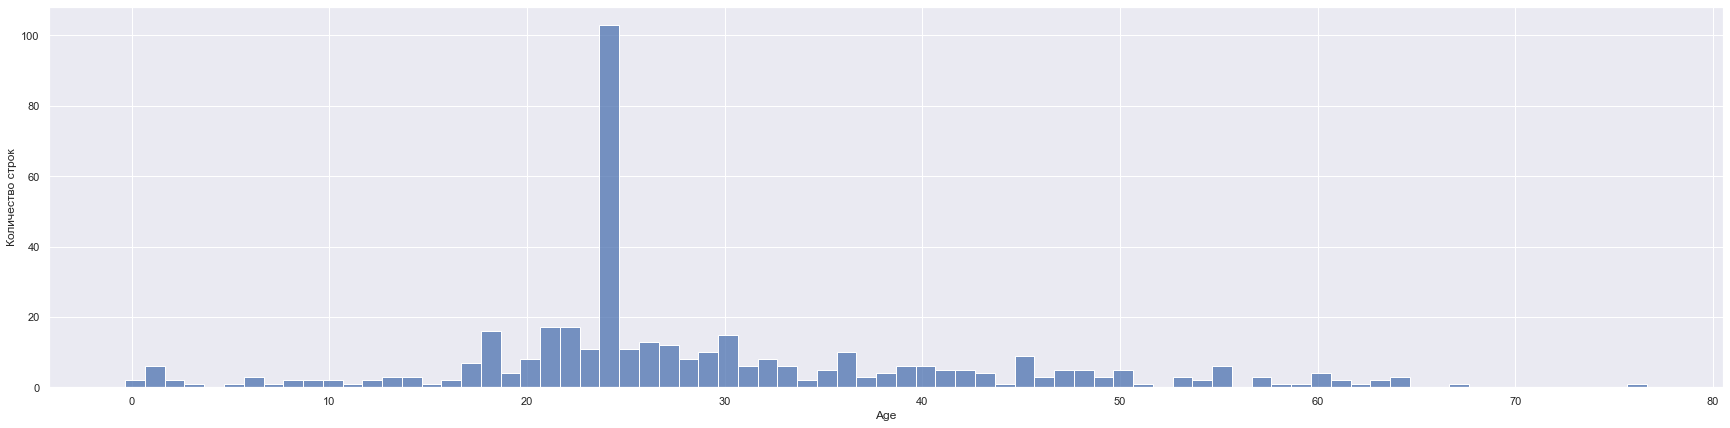

In [144]:
ahs = sns.histplot(data=test_df, x='Age', discrete=True)
ahs.set_ylabel('Количество строк')
#ahs.set_title('Гистограмма распределения времени начала нагрева дугой', fontsize=25);

### Подготовка данных к обучению

In [145]:
# удалим столбцы PassengerId, Name, Ticket, age_name, Cabin
train_df = train_df.drop(['Cabin', 'PassengerId', 'Name', 'age_name', 'Ticket'], axis=1)

In [146]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [147]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [152]:
train_df = train_df.dropna(subset = ['Embarked'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [153]:
feature_train = train_df[['Pclass', 'Sex', 'SibSp', 'Fare', 'Age', 'Parch', 'Embarked']]
target_train = train_df[['Survived']]

In [154]:
feature_train.shape

(889, 7)

In [164]:
target_train.shape

(666, 1)

In [165]:
target_train.value_counts()

Survived
0           412
1           254
dtype: int64

In [156]:
from sklearn.model_selection import train_test_split

In [157]:
features_train, features_test, target_train, target_test = train_test_split(feature_train, target_train, test_size = .25, random_state=12345)

In [158]:
# проверка
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(666, 7)
(223, 7)
(666, 1)
(223, 1)


In [159]:
RANDOM_STATE = 42

In [160]:

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

In [161]:
# посчитаем фолды
folds = KFold(n_splits=3,  shuffle=True, random_state=RANDOM_STATE)

In [162]:
cat_features = list(features_train.select_dtypes(include=['object']).columns)
cat_features

['Sex', 'Embarked']

In [167]:
%%time
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, scale_pos_weight= 0.61)

params = {'learning_rate': [0.01, 0.03, 0.25, 0.001],
            'n_estimators' : [x for x in range(50,260,50)],
            'verbose' : [0, 20, 50],
            'max_depth' : [2, 5, 10, 15]
    }
grid_cv = GridSearchCV(estimator=model_cb, 
                           param_grid=params, 
                           n_jobs=-1,
                           scoring='accuracy', 
                           cv=folds)
grid_cv.fit(features_train, target_train, cat_features=cat_features)
rmse_gr_cat = grid_cv.best_score_
print('Best hyperparams: ', grid_cv.best_params_)
print('accuracy', rmse_gr_cat)

Best hyperparams:  {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 250, 'verbose': 0}
accuracy 0.8498498498498499
CPU times: total: 9.31 s
Wall time: 12min 40s


In [168]:
features_train_lgb = features_train.copy()
features_test_lgb = features_test.copy()
for cat in cat_features:
    features_train_lgb[cat] = features_train_lgb[cat].astype('category')
    features_test_lgb[cat] = features_test_lgb[cat].astype('category')
features_train_lgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666 entries, 603 to 483
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    666 non-null    int64   
 1   Sex       666 non-null    category
 2   SibSp     666 non-null    int64   
 3   Fare      666 non-null    float64 
 4   Age       666 non-null    float64 
 5   Parch     666 non-null    int64   
 6   Embarked  666 non-null    category
dtypes: category(2), float64(2), int64(3)
memory usage: 32.8 KB


In [169]:
%%time
model_lgb = LGBMClassifier(random_state=RANDOM_STATE, objective = 'binary')




params_lgb = {'learning_rate': [0.01, 0.03, 0.25, 0.001],
            'n_estimators' : [x for x in range(50,360,50)],
            'colsample_bytree': [0.7, 0.8, 0.9],
             #'subsample': [0.7, 0.8, 0.9],
              #'min_child_samples': [5, 10, 15],
            'max_depth' : [x for x in range(1,20,2)]
    }
grid_cv_lgb = GridSearchCV(estimator=model_lgb, 
                           param_grid=params_lgb, 
                           n_jobs=-1,
                           scoring='accuracy', 
                           cv=folds)
grid_cv_lgb.fit(features_train_lgb, target_train, categorical_feature=cat_features)
scores_lgb = grid_cv_lgb.best_score_
print('Best hyperparams: ', grid_cv_lgb.best_params_)
print('accuracy', scores_lgb)

Best hyperparams:  {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 300}
accuracy 0.8393393393393395
CPU times: total: 3.48 s
Wall time: 15.7 s


In [171]:
model_test = CatBoostClassifier(random_state=RANDOM_STATE, 
                            scale_pos_weight= 0.61, 
                            learning_rate = 0.03, 
                            max_depth = 5, 
                            n_estimators = 250,
                           verbose = 0)

model_test.fit(features_train_lgb, target_train, cat_features=cat_features)
preduction = model_test.predict(features_test_lgb)
accuracy_test = accuracy_score(target_test, preduction)
print(accuracy_test)

0.7847533632286996


In [172]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [173]:
feature_test_2 = test_df[['Pclass', 'Sex', 'SibSp', 'Fare', 'Age', 'Parch', 'Embarked']]

In [174]:
pred_test = model_test.predict(feature_test_2)

In [175]:
gender_submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
gender_submission['PassengerId'] = test_df['PassengerId']
gender_submission['Survived'] = pred_test

In [176]:
gender_submission = gender_submission[['PassengerId', 'Survived']]
gender_submission


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [177]:
gender_submission.to_csv('/Users/ven89/OneDrive/Desktop/Питон соревнования/Титаник/gender_submission_3.csv', index=False)